# Calibration

(If GitHub truncates the output, you can see the full rendering in Google Colab:
Clink [here](https://nbviewer.org/github/Kanato-Nakakuni/ComputationalMacro/blob/main/Lec05_Calibration.ipynb).)  

- So far, we have solved the household’s problem or general equilibrium by setting deep parameters (e.g., time discount factor) arbitrary.  
<br>
- In this lecture, we learn how to determine these parameter values.  
<br>
- This procedure, in the context of macroeconomics, is referred to as **Calibration**.  
  - A procedure to determine the parameter values of a quantitative macroeconomic model so that the model replicates key empirical regularities relevant to the research question at hand.  

In our model, the parameter values to be set include:

- Discount factor $\beta$  
- Relative weight on consumption $\omega$  
- Capital share $\alpha$  
- Depreciation rate $\delta$  
- Income replacement rate $\theta$  


---

### How?

Some parameters are taken directly from data or estimated outside the model.  

For example:
- The capital share $\alpha$ and depreciation rate $\delta$ are often obtained from national accounts data.  
- If the model includes a stochastic income process, its parameters are usually estimated using micro-level income data.  

Other parameters are calibrated so that the model replicates **targeted moments**—key empirical patterns.  
For example, in macroeconomic models:
- $\beta$ is often chosen so that the model implies a capital-output ratio $K/Y$ close to the one observed in data.  
- $\omega$ is often chosen so that the model replicates the share of time spent in leisure (or work) observed in data.

---

### Two-Step Calibration

We typically follow an approach often referred to as two-step calibration:  

1. **Step 1**: Set parameters based on external data or literature.  
2. **Step 2**: Determine remaining parameters so that the model replicates targeted moments.  

Researchers must decide which parameters fall into each step. This depends on:
- Whether the parameter is directly observable  
- Whether reliable empirical estimates are available  
- What is central to the research question (See below)  

---

### Example: Target Selection

Suppose we consider the pension income replacement rate $\theta$. It could be directly set using institutional data. However, many studies calibrate $\theta$ **within the model** so that it reproduces the **pension-to-GDP ratio**. This is particularly important when analyzing:  
- The macroeconomic consequences of demographic change
- Fiscal impacts of pension reform  

In those cases, the pension-to-GDP ratio is the key moment to match, not the raw value of $\theta$ itself.

---

### Calibration Strategy in Our Model

We follow this specific calibration procedure:

### Step 1: Externally Set Parameters

Set based on empirical consensus:  
- $\alpha = 0.33$  
- $\delta = 0.1$ (depends on the model’s period length)  
- $\sigma = 2.0$ (Literature)

### Step 2: Internally Calibrated Parameters

Choose values to match targeted moments:  
- $\beta$: calibrated so that $K/Y = 4.0$  
- $\omega$: chosen so that households work 1/3 of their available time  
- $\theta$: set so that the model replicates a pension-to-GDP ratio of 0.1 (i.e., 10% of GDP is spent on pensions)  

---

## Algorithm Outline

To implement calibration, we add an **outer loop** around the model solution:

1. Set $\alpha = 0.33$, $\delta = 0.1$, and $\sigma=2.0$. (1st step)  
<br>
2. Make initial guesses for parameters to determine in 2nd step $(\beta, \omega, \theta)$  
<br>
3. Solve the general equilibrium  
<br>
4. Compute the implied values of the targeted moments  
<br>
5. If the model moments do not match the targets, update the guesses and repeat until convergence  
---


### Procedure

1. Construct `struct` named Parameters, which contains (β, σ, ω, θ, α, δ, J, JR, muj).  
<br>
2. Construct a function `solve_lifecycle` that returns household age-profile of asset and labor, taking prices, tax, and parameters as inputs.  
<br>
3. Construct a function `solve_GE` that solves GE and returns model-implied targeted moments (e.g., $K/Y$), taking initial guesses and parameters as inputs, using `solve_lifecycle`.  
<br>
4. Follow Algorithm Outline above, using `struct`, `solve_lifecycle`, and `solve_GE`.
---

In [4]:
# step 1: construct struct
struct Parameters
    β::Float64
    σ::Float64
    ω::Float64
    θ::Float64
    α::Float64
    δ::Float64
    J::Int
    JR::Int
    muj::Vector{Float64}
end

In [1]:
# step 2: function for household problem
function solve_lifecycle(r,w,τ,p)
    
    ### inputs ###
    # r: interest rate
    # w: wage rate
    # τ: labor income tax rate 
    # p: struct, p = Parameters(β, σ, ω, θ, α, δ, J, JR, muj)
    ###############
    
    # retrieve (relevant) parameters
    β = p.β
    σ = p.σ
    ω = p.ω
    θ = p.θ
    J = p.J
    JR = p.JR
    ##########

    # discretization for asset space
    mina = 0.0 # lower bound (close to zero but not exactly (to avoid c=0))
    maxa = 10.0  # upper bound
    na   = 1000  # number of grid
    grida = collect(LinRange(mina,maxa,na)); # construct discretized asset space

    # value function and policy functions
    V = zeros(na,J); # value function V(a,j)
    Va = zeros(na);  # vector for grid search
    apol = zeros(na,J); # policy function for saving (value) a(a,J)
    apol_arg = ones(Int,na,J); # policy function for saving (index over asset space, grida)
    cpol = zeros(na,J)  # policy function for consumption c(a,J)
    hpol = zeros(na,J) # policy function for labor 

    penalty=-1.e+8

    # step 4: solving household problem by backward induction
    for jc in J:-1:1 # solve backward
        
        acc_start = 1 # for speed up
        v0=penalty

        for ac in 1:na

            if (jc==J) # compute final consumption given a
                c = (1.0+r)*grida[ac]+w*θ
                if (c>0)
                    V[ac,jc]=((c^ω)^(1.0-σ))/(1.0-σ) # leisure=1
                else # "punish" c<=0
                    V[ac,jc]=penalty
                end

                cpol[ac,jc]=c; # store it in policy function for c
                hpol[ac,jc]=0.0; # no work in retirement period
                
            else # working or retirement period (except for the final period)

                for acc in acc_start:na

                    # difference btw. working and retirement age; labor income, pension, and labor supply choice.
                    if (jc<=JR)
                        A = (1.0+r)*grida[ac]-grida[acc]
                        ATW = (1-τ)*w # AfterTaxWage
                        l = (1.0-ω) * (1.0 + A/ATW)
                        if (l>1) # l is bounded above by 1 (h is bounded below by 0)
                            l=1.0 # corner solution. we will check another condition l>0 below.
                        end
                        pension = 0.0
                    else # if (jc>JR && jc<J), retirement period
                        l = 1.0
                        pension = w*θ
                    end

                    c = (1-τ)*w*(1-l) + (1+r)*grida[ac]-grida[acc] + pension

                    if (c>0 && l>0)
                        Va[acc] = ((c^ω * l^(1.0-ω))^(1.0-σ))/(1.0-σ) + β*V[acc,jc+1]
                    else
                        Va[acc] = penalty
                    end

                    if (Va[acc]>v0)
                        v0=Va[acc]
                        acc_start=acc
                    else
                        break
                    end

                end

                arg = acc_start
                # arg = argmax(Va) # you may also use this instead

                apol_arg[ac,jc]=arg
                apol[ac,jc] = grida[arg]
                V[ac,jc] = Va[arg]

                if (jc<=JR) # working period
                    A = (1.0+r)*grida[ac]-grida[arg]
                    ATW = (1-τ)*w # AfterTaxWage
                    l = (1.0-ω) * (1.0 + A/ATW)
                    pension = 0.0
                else # if (jc>JR && jc<J), retirement period
                    l = 1.0
                    pension = w*θ
                end

                cpol[ac,jc]=(1.0-τ)*w*(1.0-l) + (1.0+r)*grida[ac]-grida[arg] + pension;
                hpol[ac,jc]=1.0-l
                
            end
        end
    end

    # find asset profile aj
    aj = zeros(J);
    hj = zeros(J);
    cj = zeros(J);

    arg_previous=1;
    aj[1]=grida[arg_previous]; # start from no-asset
    hj[1]=hpol[arg_previous,1]
    cj[1]=cpol[arg_previous,1]
    
    for jc in 2:J
        # find today's asset position
        arg = apol_arg[arg_previous,jc-1];
        # choices
        aj[jc]=grida[arg];
        hj[jc]=hpol[arg,jc]
        cj[jc]=cpol[arg,jc]

        arg_previous=arg # update
    end

    return aj,hj,cj # outputs
    
end

solve_lifecycle (generic function with 1 method)

In [2]:
function solve_GE(r,w,τ,p)

    ### inputs ###
    # r: initial guess for interest rate
    # w: initial guess for wage rate
    # τ: initial guess for labor income tax rate
    # p: Parameters struct
    ###############

    ### retrieve (relevant) parameters ###
    θ = p.θ
    α = p.α
    δ = p.δ
    J = p.J
    JR = p.JR
    muj = p.muj
    #######################################

    # convergence criteria and initial values for dif
    ε =[1.e-3, 1.e-3, 1.e-3]; # for (K,H,τ)
    d =[1.0, 1.0, 1.0]; # for (K,H,τ)

    iter=1;
    max_iter=100; # for when something is wrong.

    # returned variables need to be set in advance outside of while loop, error otherwise.
    K_Y=1.0  # capital-to-output ratio
    Work=1.0 # fraction of time spent in work
    P_Y=1.0  # Pension-to-GDP ratio
    K = 1.0; H = 1.0;

    while any(d .> ε)

        # Solve household problems

        aj,hj,cj = solve_lifecycle(r,w,τ,p)

        # Compute the implied aggregate variables
        imp_K = sum(aj.*muj)
        imp_H = sum(hj.*muj)
        imp_τ = θ*sum(muj[JR+1:J])/imp_H

        # compute the implied prices with implied quantities (imp_K,imp_H)
        imp_r = α*(imp_K/imp_H)^(α-1.0) - δ
        imp_w = (1-α)*(imp_K/imp_H)^α

        # Check if the guesses are right. If not, update.
        dif_r = abs(r-imp_r)/r
        dif_w = abs(w-imp_w)/w
        dif_τ = abs(τ-imp_τ)/τ

        d .= [dif_r,dif_w,dif_τ];

        # Update guess (a linear combination of guessed and implied values)
        adj=0.1; # ADJustment factor (weight)
        r = imp_r*adj + r*(1.0-adj)
        w = imp_w*adj + w*(1.0-adj)
        τ = imp_τ*adj + τ*(1.0-adj)

        iter+=1;

        if (iter>max_iter)
            break
        end

        
        K=imp_K; H=imp_H;
        Y = K^α * H^(1.0-α) # output
        P = w*θ*sum(muj[JR+1:J]) # pension expenditure

        # compute targeted moments
        K_Y = K/Y # capital output ratio
        Work = sum(hj[1:JR])/JR # this is okay as, in this case, age distribution is uniform
        P_Y = P/Y # pension GDP ratio

    end

    return K_Y,Work,P_Y,K,H,τ

end

solve_GE (generic function with 1 method)

In [5]:
# calibration
using Printf

# 0. Set target
Targ_KY   = 4.0  # capital output ratio
Targ_Work = 0.33 # share of time spent on work
Targ_PY   = 0.1  # pension output ratio

# OUTPUT: Need to be set in advance outside of while loop
KY   = 1.0 # capital output ratio
Work = 1.0 # share of time spent on work
PY   = 1.0 # pension output ratio

# 1. setting parameter values and making initial guesses
# Exogenously set parameter values
σ=2.0; α=0.33; δ=0.1; J=61; JR=46; muj=fill(1.0/J, J)
# Endogenous (initial guess)
β=0.98; ω=0.5; θ=0.3
############################

p = Parameters(β, σ, ω, θ, α, δ, J, JR, muj) # construct struct

# Initial guess for solving GE
r = 0.02;
w = 1.0;
τ = 0.1

# Convergence criteria and initial values for dif
d=[1.0, 1.0, 1.0]; # for (K_Y,Work,P_Y)
ε=[1.e-3, 1.e-3, 1.e-3]; # for (K_Y,Work,P_Y)

iter=1
max_iter=500; # for when something is wrong.

# (optional) to plot some results
Model_KY = zeros(max_iter)
Model_Work = zeros(max_iter)
Model_PY = zeros(max_iter)

β_iter = zeros(max_iter)
ω_iter = zeros(max_iter)
θ_iter = zeros(max_iter)

while any(d.>ε)
    
    # solve model and get model-implied moments
    KY,Work,PY,K,H,τ = solve_GE(r,w,τ,p)

    ### Retrieve relevant Parameters for update 
    β = p.β; ω = p.ω; θ = p.θ

    ### (optional) to plot some results ###
    Model_KY[iter]=KY
    Model_Work[iter]=Work
    Model_PY[iter]=PY

    β_iter[iter]=β
    ω_iter[iter]=ω
    θ_iter[iter]=θ
    ########################################

    # Check if model-implied moment is close enough to its target. If not, update.
    dif_KY = abs(Targ_KY-KY)/Targ_KY
    dif_Wo = abs(Targ_Work-Work)/Targ_Work
    dif_PY = abs(Targ_PY-PY)/Targ_PY

    d .= [dif_KY,dif_Wo,dif_PY];

    if (iter>max_iter)
        break
    end
    # @printf("iter = %d    d = %.5f\n", iter, maximum(d))
    iter+=1;

    # update
    denom = 50.0

    if (KY>Targ_KY) # save too much
        β=β*(1.0-dif_KY/denom)
    else
        β=β*(1.0+dif_KY/denom)
    end

    if (Work>Targ_Work) # work too much
        ω=ω*(1.0-dif_Wo/denom)
    else
        ω=ω*(1.0+dif_Wo/denom)
    end

    if (PY>Targ_PY) # give too much pension
        θ=θ*(1.0-dif_PY/denom)
    else
        θ=θ*(1.0+dif_PY/denom)
    end

    # update struct with new values for (β,ω,θ)
    p = Parameters(β, σ, ω, θ, α, δ, J, JR, muj)

end


@show iter, d
using Printf
@printf("K/Y = %.5f\nWork = %.5f\nP/Y = %.5f\n", KY,Work,PY)
@printf("beta = %.5f\nomega = %.5f\ntheta = %.5f\n", β,ω,θ)



(iter, d) = (415, [0.0003092811410714269, 0.00028835430115639854, 0.000831853993129017])
K/Y = 4.00124
Work = 0.33010
P/Y = 0.10008
beta = 1.03075
omega = 0.27749
theta = 0.15119


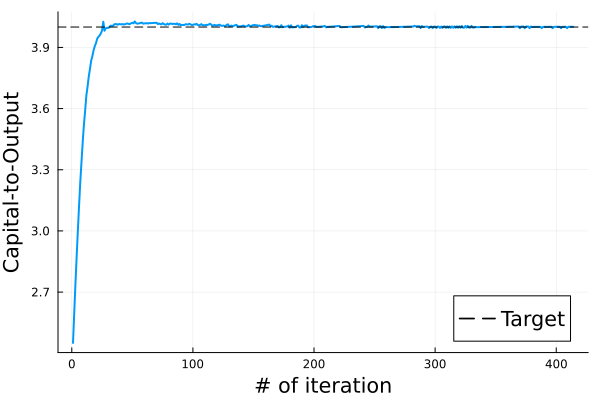

In [6]:
# plot convergence of targeted moment (K/Y)
using Plots
plot(1:iter-1, Model_KY[1:iter-1],
    xlabel="# of iteration",
    ylabel="Capital-to-Output",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([Targ_KY], lw=1, lc=:black, ls=:dash,label="Target")

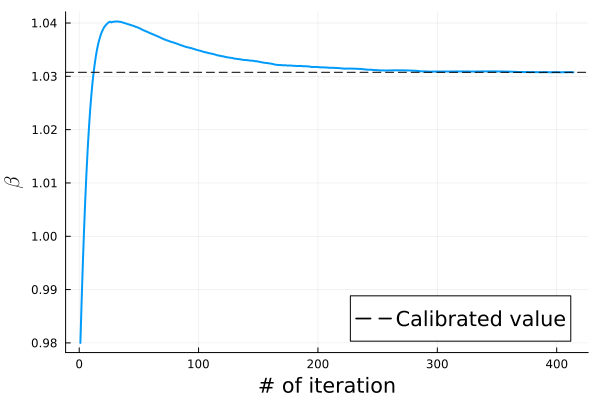

In [7]:
# Convergence of beta
using LaTeXStrings
plot(1:iter-1, β_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\beta",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([β], lw=1, lc=:black, ls=:dash, label="Calibrated value")

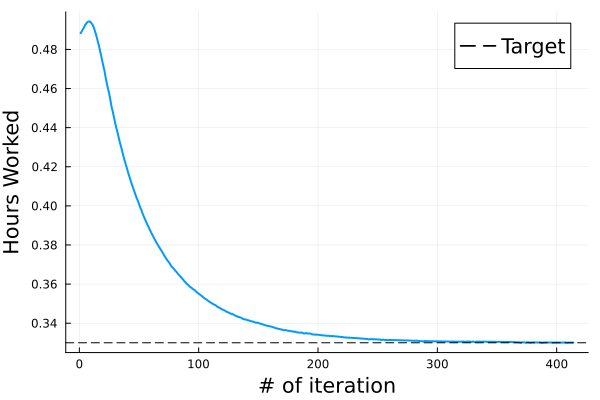

In [8]:
using Plots
plot(1:iter-1, Model_Work[1:iter-1],
    xlabel="# of iteration",
    ylabel="Hours Worked",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([Targ_Work], lw=1, lc=:black, ls=:dash, label="Target")

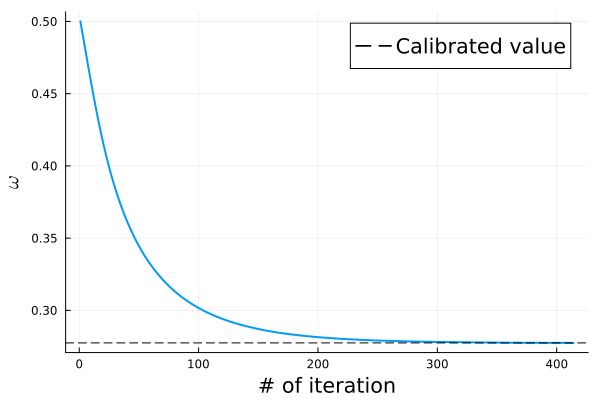

In [9]:
# Convergence of omega
using LaTeXStrings
plot(1:iter-1, ω_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\omega",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([ω], lw=1, lc=:black, ls=:dash, label="Calibrated value")

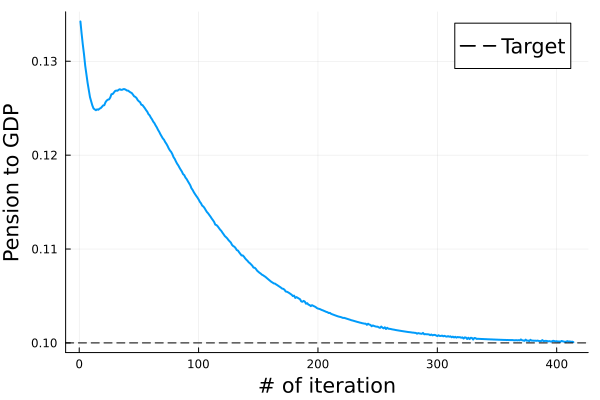

In [10]:
using Plots
plot(1:iter-1, Model_PY[1:iter-1],
    xlabel="# of iteration",
    ylabel="Pension to GDP",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([Targ_PY], lw=1, lc=:black, ls=:dash, label="Target")

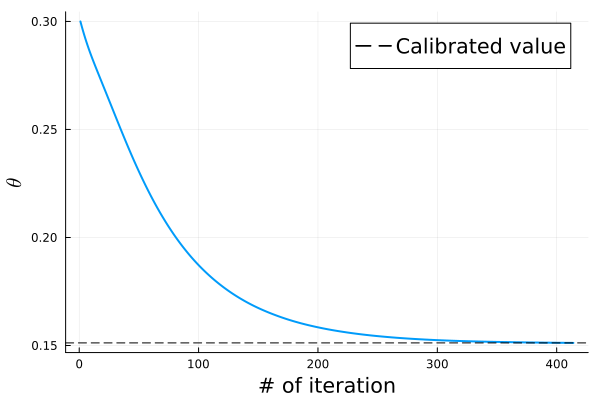

In [11]:
# Convergence of theta
using LaTeXStrings
plot(1:iter-1, θ_iter[1:iter-1],
    xlabel="# of iteration",
    ylabel=L"\theta",
    title="",
    lw=2,
    label="",
    xguidefont = font(14),   # font size for x-axis label
    yguidefont = font(14),
    legendfontsize = 14)    # font size for y-axis label)
hline!([θ], lw=1, lc=:black, ls=:dash, label="Calibrated value")